# Baseline-Dropout

## Data Prep

In [56]:
#imports
import torch
import torchvision #PyTorch models, datasets, transofmrations etc
import torchvision.transforms as transforms

In [57]:
#Download Train And Test Data
train_data = torchvision.datasets.MNIST(root = "./MNIST_train", download = True, train = True, transform = transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root = "./MNIST_test", download = True, train = False, transform = transforms.ToTensor())

In [58]:
#Startified Split Of Train Data Into Training and Validataion Sets

#The following thread was referred to for writing the code in this cell
#https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import SubsetRandomSampler, DataLoader

#Get The Train Data Targets Array
labels = train_data.targets
#Get The Splitting Indices - use 80-20 split again.
train_ind, val_ind = train_test_split(np.arange(len(labels)), test_size = 0.2, shuffle = True, stratify = labels)

tr_sampler = SubsetRandomSampler(train_ind)
val_sampler = SubsetRandomSampler(val_ind)

#Define Batch Size For Mini Batch Gradient Descent
# batch_size = 128
batch_size = 64

#Create Data Loaders For Training And Validation Set
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=tr_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)


In [59]:
#Create Data Loaders For Test Set
test_loader = DataLoader(test_data, batch_size=batch_size)

# Dropout = 0.25

## Modelling

In [60]:
#Define Model Architecture with Dropout
import torch.nn as nn 

#The following sources were referred to for wrting the code in thie cell
# https://androidkt.com/initialize-weight-bias-pytorch/

# https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

class BaselineCnn(nn.Module):
  def __init__(self):
    super(BaselineCnn, self).__init__()

    #Define Layers
    self.conv1 = nn.Conv2d(1,12,8)
    self.conv2 = nn.Conv2d(12,12,4)
    self.lin1 = nn.Linear(3888,30)
    self.lin2 = nn.Linear(30, 10)
    self.ReLU = nn.ReLU()

    self.dropout = nn.Dropout(0.25)

    nn.init.xavier_uniform(self.conv1.weight)
    nn.init.xavier_uniform(self.conv2.weight)
    nn.init.xavier_uniform(self.lin1.weight)
    nn.init.xavier_uniform(self.lin2.weight)

    #Add Convolutional Layers
    self.cnn_layers = nn.Sequential(
        self.conv1,
        nn.ReLU(),
        self.conv2,
        nn.ReLU()
    )

    #Add Fully Connected Layers
    self.fc_layers = nn.Sequential(
        self.lin1,
        nn.ReLU(),
        self.lin2
    )

  

  #Define Forward Path
  def forward(self, x):

    x = self.ReLU(self.conv1(x))
    x = self.dropout(x)

    x = self.ReLU(self.conv2(x))
    x = self.dropout(x)

    x = x.view(x.size(0), -1)

    x = self.ReLU(self.lin1(x))
    x = self.dropout(x)

    x = self.lin2(x)

    return x



In [61]:
model = BaselineCnn()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [62]:
#Create Function To Evaluate The Trained Model when given a dataloader and a model
def evall(dl, model):  
    tot = 0
    corr = 0
    # for data in dataloader:
    for batch in dl:
        ip, op = batch
        preds = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(preds.data, 1)
        #Increment The Number Of Samples Tested Against
        tot += op.size(0)
        #Increment The Number Of Correctly Classified Samples
        corr += (pred == op).sum().item()

    acc = 100 * corr / tot
    print('Accuracy:', acc, '%')
    return acc

## Training

In [63]:
#Define The Loss Function, Training Optimizer and The Learning Rate Scheduler

#The following sources were referred to for writing the code in this cell

# https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

import torch.optim as optim

#Define Start Leanring Rate and Momentum

start_lr = 0.05
momentum = 0.9

loss_function = nn.CrossEntropyLoss()
opti = optim.SGD(model.parameters(), lr = start_lr, momentum=momentum)

#create the learning rate scheduler to change lr to 10% of lr every 10 epochs
lrscheduler = optim.lr_scheduler.StepLR(opti, step_size=10, gamma = 0.1)

In [64]:
#Train on GPU
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
td = torch.device(dev)
print(td)

cuda:0


In [65]:
# The following sources were referred to for writing the code in the below cells
# https://github.com/satyajitghana/PadhAI-Course/blob/master/colab-notebooks/16_PyTorchCNN.ipynb
# https://androidkt.com/initialize-weight-bias-pytorch/
# https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE
# https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5
# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs


In [66]:
tbs = int(60000*0.8)
vbs = int(60000*0.2)
tdl = DataLoader(train_data, batch_size=tbs, sampler=tr_sampler)
vdl = torch.utils.data.DataLoader(train_data, batch_size=vbs, sampler=val_sampler)

epoch_tr_losses = []
epoch_val_losses = []
epoch_val_accs = []
epoch_tr_accs = []
max_epochs = 20

#Define Early Stopping Patience - here 2 epochs
es_patience_count = 8
es_count = 0


for epoch in range(max_epochs):

    # for ind, data in enumerate(train_loader):
    for data in train_loader:

        ip, op = data

        opti.zero_grad()

        preds = model(ip)

        loss = loss_function(preds, op)
        loss.backward()
        opti.step()
        
    lrscheduler.step()

    for td in tdl:
      tr_ip, tr_op = td
      tr_preds = model(tr_ip)
      lt = loss_function(tr_preds, tr_op)
      epoch_tr_losses.append(lt.item())

    for vd in vdl:
      val_ip, val_op = vd
      val_preds = model(val_ip)
      lt = loss_function(val_preds, val_op)
      epoch_val_losses.append(lt.item())
        
    if epoch % 10 == 0:
      print(f"Epoch Number: {epoch} lr: {opti.param_groups[0]['lr']}")

    val_acc = evall(valid_loader, model)
    tr_acc = evall(train_loader, model)

    epoch_val_accs.append(val_acc)
    epoch_tr_accs.append(tr_acc)

    #Early Stopping based on vaidation acc

    if epoch == 0:
      best_loss = epoch_val_losses[0]
    print(epoch_val_losses[epoch] , best_loss)

    if epoch_val_losses[epoch] < best_loss:
      best_loss = epoch_val_losses[epoch]
      torch.save(model, 'best_model.pth')
    else:
      es_count += 1

    print(f"Epoch Number: {epoch}/{max_epochs}, Validation Accuracy: {val_acc}, Train Accuracy: {tr_acc}, Training Loss: {epoch_tr_losses[epoch]}, Validation Loss: {epoch_val_losses[epoch]}, Learning Rate: {opti.param_groups[0]['lr']}")

    # "Implement Early Stopping
    if es_count > es_patience_count:
      print(f'Early Stopping Implemented at epoch {epoch}')
      break

Epoch Number: 0 lr: 0.05
Accuracy: 93.65 %
Accuracy: 93.725 %
0.21231336891651154 0.21231336891651154
Epoch Number: 0/20, Validation Accuracy: 93.65, Train Accuracy: 93.725, Training Loss: 0.20606647431850433, Validation Loss: 0.21231336891651154, Learning Rate: 0.05
Accuracy: 95.25833333333334 %
Accuracy: 95.80625 %
0.16215477883815765 0.21231336891651154
Epoch Number: 1/20, Validation Accuracy: 95.25833333333334, Train Accuracy: 95.80625, Training Loss: 0.1408303827047348, Validation Loss: 0.16215477883815765, Learning Rate: 0.05
Accuracy: 95.325 %
Accuracy: 95.64375 %
0.18074604868888855 0.16215477883815765
Epoch Number: 2/20, Validation Accuracy: 95.325, Train Accuracy: 95.64375, Training Loss: 0.14526090025901794, Validation Loss: 0.18074604868888855, Learning Rate: 0.05
Accuracy: 96.05833333333334 %
Accuracy: 96.66458333333334 %
0.13608990609645844 0.16215477883815765
Epoch Number: 3/20, Validation Accuracy: 96.05833333333334, Train Accuracy: 96.66458333333334, Training Loss: 0.1

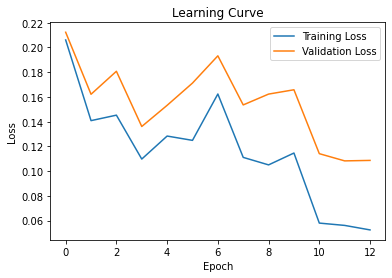

In [67]:
#Plot Learning Curves
import matplotlib.pyplot as plt
plt.plot(epoch_tr_losses, label = 'Training Loss')
plt.plot(epoch_val_losses, label = 'Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
evall(test_loader, model)

Accuracy: 97.7 %


97.7

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def cal_confusion_matrix(dl, model):
    preds = torch.empty((0))
    labels = torch.empty((0))
    for batch in dl:
        ip, op = batch
        pred = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(pred.data, 1)
        #Increment The Number Of Samples Tested Against
        #Increment The Number Of Correctly Classified Samples
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, op))
    
    ConfusionMatrixDisplay.from_predictions(labels, preds)
    plt.show()

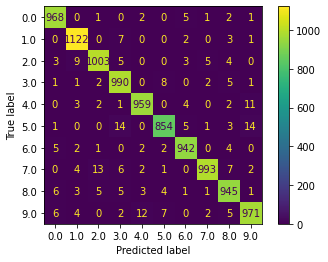

In [70]:
cal_confusion_matrix(test_loader, model)


# Dropout = 0.5

## Modelling

In [71]:
#Define Model Architecture with Dropout
import torch.nn as nn 

# The following sources were referred to for writing the code in the below cells

# https://androidkt.com/initialize-weight-bias-pytorch/

# https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

class BaselineCnn(nn.Module):
  def __init__(self):
    super(BaselineCnn, self).__init__()

    #Define Layers
    self.conv1 = nn.Conv2d(1,12,8)
    self.conv2 = nn.Conv2d(12,12,4)
    self.lin1 = nn.Linear(3888,30)
    self.lin2 = nn.Linear(30, 10)
    self.ReLU = nn.ReLU()

    self.dropout = nn.Dropout(0.5)

    nn.init.xavier_uniform(self.conv1.weight)
    nn.init.xavier_uniform(self.conv2.weight)
    nn.init.xavier_uniform(self.lin1.weight)
    nn.init.xavier_uniform(self.lin2.weight)

    #Add Convolutional Layers
    self.cnn_layers = nn.Sequential(
        self.conv1,
        nn.ReLU(),
        self.conv2,
        nn.ReLU()
    )

    #Add Fully Connected Layers
    self.fc_layers = nn.Sequential(
        self.lin1,
        nn.ReLU(),
        self.lin2
    )

  

  #Define Forward Path
  def forward(self, x):

    x = self.ReLU(self.conv1(x))
    x = self.dropout(x)

    x = self.ReLU(self.conv2(x))
    x = self.dropout(x)

    x = x.view(x.size(0), -1)

    x = self.ReLU(self.lin1(x))
    x = self.dropout(x)

    x = self.lin2(x)

    return x



In [72]:
model = BaselineCnn()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [73]:
#Create Function To Evaluate The Trained Model when given a dataloader and a model
def evall(dl, model):  
    tot = 0
    corr = 0
    # for data in dataloader:
    for batch in dl:
        ip, op = batch
        # inputs, labels = data
        preds = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(preds.data, 1)
        #Increment The Number Of Samples Tested Against
        # tot += labels.shape(0)
        tot += op.size(0)
        #Increment The Number Of Correctly Classified Samples
        corr += (pred == op).sum().item()

    acc = 100 * corr / tot
    print('Accuracy:', acc, '%')
    return acc

def evaluation(dataloader, net):
  total, correct = 0, 0
  for data in dataloader:
      inputs, labels = data
      outputs = net(inputs)
      _, pred = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (pred == labels).sum().item()

  print(correct,total)
  return 100 * correct / total

## Training

In [74]:
#Define The Loss Function, Training Optimizer and The Learning Rate Scheduler

# The following sources were referred to for writing the code in the below cells

# https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

import torch.optim as optim

#Define Start Leanring Rate and Momentum

start_lr = 0.05
momentum = 0.9

loss_function = nn.CrossEntropyLoss()
opti = optim.SGD(model.parameters(), lr = start_lr, momentum=momentum)

#create the learning rate scheduler to change lr to 10% of lr every 10 epochs
lrscheduler = optim.lr_scheduler.StepLR(opti, step_size=10, gamma = 0.1)

In [75]:
#Train on GPU
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
td = torch.device(dev)
print(td)

cuda:0


In [76]:
# loss_arr = []

tbs = int(60000*0.8)
vbs = int(60000*0.2)
tdl = DataLoader(train_data, batch_size=tbs, sampler=tr_sampler)
vdl = torch.utils.data.DataLoader(train_data, batch_size=vbs, sampler=val_sampler)


epoch_tr_losses = []
epoch_val_losses = []
epoch_val_accs = []
epoch_tr_accs = []
max_epochs = 20

#Define Early Stopping Patience - here 2 epochs
es_patience_count = 8
es_count = 0


for epoch in range(max_epochs):

    for data in train_loader:

        ip, op = data

        opti.zero_grad()

        preds = model(ip)

        loss = loss_function(preds, op)
        loss.backward()
        opti.step()
        
    lrscheduler.step()

    for td in tdl:
      tr_ip, tr_op = td
      tr_preds = model(tr_ip)
      lt = loss_function(tr_preds, tr_op)
      epoch_tr_losses.append(lt.item())

    for vd in vdl:
      val_ip, val_op = vd
      val_preds = model(val_ip)
      lt = loss_function(val_preds, val_op)
      epoch_val_losses.append(lt.item())
        
    if epoch % 10 == 0:
      print(f"Epoch Number: {epoch} lr: {opti.param_groups[0]['lr']}")

    val_acc = evall(valid_loader, model)
    tr_acc = evall(train_loader, model)

    epoch_val_accs.append(val_acc)
    epoch_tr_accs.append(tr_acc)

    #Early Stopping based on vaidation acc

    if epoch == 0:
      best_loss = epoch_val_losses[0]
    print(epoch_val_losses[epoch] , best_loss)

    if epoch_val_losses[epoch] < best_loss:
      best_loss = epoch_val_losses[epoch]
      #save current model
      torch.save(model, 'best_model.pth')
    else:
      es_count += 1

    print(f"Epoch Number: {epoch}/{max_epochs}, Validation Accuracy: {val_acc}, Train Accuracy: {tr_acc}, Training Loss: {epoch_tr_losses[epoch]}, Validation Loss: {epoch_val_losses[epoch]}, Learning Rate: {opti.param_groups[0]['lr']}")

    #Implement Early Stopping
    if es_count > es_patience_count:
      print(f'Early Stopping Implemented at epoch {epoch}')
      break

Epoch Number: 0 lr: 0.05
Accuracy: 77.55 %
Accuracy: 78.5625 %
0.7077416181564331 0.7077416181564331
Epoch Number: 0/20, Validation Accuracy: 77.55, Train Accuracy: 78.5625, Training Loss: 0.6769473552703857, Validation Loss: 0.7077416181564331, Learning Rate: 0.05
Accuracy: 81.8 %
Accuracy: 82.20833333333333 %
0.5942968130111694 0.7077416181564331
Epoch Number: 1/20, Validation Accuracy: 81.8, Train Accuracy: 82.20833333333333, Training Loss: 0.5612779259681702, Validation Loss: 0.5942968130111694, Learning Rate: 0.05
Accuracy: 84.40833333333333 %
Accuracy: 85.42083333333333 %
0.47413790225982666 0.5942968130111694
Epoch Number: 2/20, Validation Accuracy: 84.40833333333333, Train Accuracy: 85.42083333333333, Training Loss: 0.46171247959136963, Validation Loss: 0.47413790225982666, Learning Rate: 0.05
Accuracy: 82.51666666666667 %
Accuracy: 82.53958333333334 %
0.5782012343406677 0.47413790225982666
Epoch Number: 3/20, Validation Accuracy: 82.51666666666667, Train Accuracy: 82.539583333

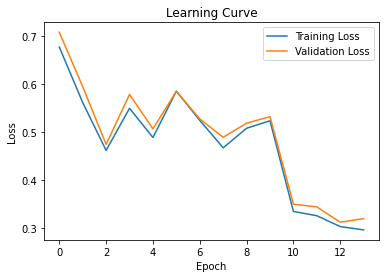

In [77]:
#Plot Learning Curves
import matplotlib.pyplot as plt
plt.plot(epoch_tr_losses, label = 'Training Loss')
plt.plot(epoch_val_losses, label = 'Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [78]:
evall(test_loader, model)

Accuracy: 91.07 %


91.07

In [79]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def cal_confusion_matrix(dl, model):
    preds = torch.empty((0))
    labels = torch.empty((0))
    for batch in dl:
        ip, op = batch
        pred = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(pred.data, 1)
        #Increment The Number Of Samples Tested Against
        #Increment The Number Of Correctly Classified Samples
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, op))
    
    ConfusionMatrixDisplay.from_predictions(labels, preds)
    plt.show()

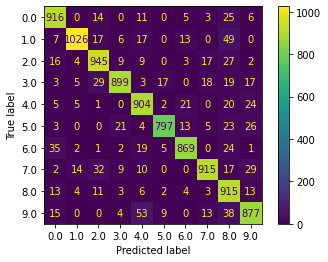

In [80]:
cal_confusion_matrix(test_loader, model)


# Dropout = 0.75

## Modelling

In [81]:
#Define Model Architecture with Dropout
import torch.nn as nn 

# The following sources were referred to for writing the code in the below cells

# https://androidkt.com/initialize-weight-bias-pytorch/

# https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

class BaselineCnn(nn.Module):
  def __init__(self):
    super(BaselineCnn, self).__init__()

    #Define Layers
    self.conv1 = nn.Conv2d(1,12,8)
    self.conv2 = nn.Conv2d(12,12,4)
    self.lin1 = nn.Linear(3888,30)
    self.lin2 = nn.Linear(30, 10)
    self.ReLU = nn.ReLU()

    self.dropout = nn.Dropout(0.75)

    nn.init.xavier_uniform(self.conv1.weight)
    nn.init.xavier_uniform(self.conv2.weight)
    nn.init.xavier_uniform(self.lin1.weight)
    nn.init.xavier_uniform(self.lin2.weight)

    #Add Convolutional Layers
    self.cnn_layers = nn.Sequential(
        self.conv1,
        nn.ReLU(),
        self.conv2,
        nn.ReLU()
    )

    #Add Fully Connected Layers
    self.fc_layers = nn.Sequential(
        self.lin1,
        nn.ReLU(),
        self.lin2
    )

  

  #Define Forward Path
  def forward(self, x):

    x = self.ReLU(self.conv1(x))
    x = self.dropout(x)

    x = self.ReLU(self.conv2(x))
    x = self.dropout(x)

    x = x.view(x.size(0), -1)

    x = self.ReLU(self.lin1(x))
    x = self.dropout(x)

    x = self.lin2(x)


    return x



In [82]:
model = BaselineCnn()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [83]:
#Create Function To Evaluate The Trained Model when given a dataloader and a model
def evall(dl, model):  
    tot = 0
    corr = 0
    # for data in dataloader:
    for batch in dl:
        ip, op = batch
        # inputs, labels = data
        preds = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(preds.data, 1)
        #Increment The Number Of Samples Tested Against
        # tot += labels.shape(0)
        tot += op.size(0)
        #Increment The Number Of Correctly Classified Samples
        corr += (pred == op).sum().item()

    acc = 100 * corr / tot
    print('Accuracy:', acc, '%')
    return acc

def evaluation(dataloader, net):
  total, correct = 0, 0
  for data in dataloader:
      inputs, labels = data
      outputs = net(inputs)
      _, pred = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (pred == labels).sum().item()

  print(correct,total)
  return 100 * correct / total

## Training

In [84]:
#Define The Loss Function, Training Optimizer and The Learning Rate Scheduler

# The following sources were referred to for writing the code in the below cells

# https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

# https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs

import torch.optim as optim

#Define Start Leanring Rate and Momentum

start_lr = 0.05
momentum = 0.9

loss_function = nn.CrossEntropyLoss()
opti = optim.SGD(model.parameters(), lr = start_lr, momentum=momentum)

#create the learning rate scheduler to change lr to 10% of lr every 10 epochs
lrscheduler = optim.lr_scheduler.StepLR(opti, step_size=10, gamma = 0.1)

In [85]:
#Train on GPU
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
td = torch.device(dev)
print(td)

cuda:0


In [86]:
# loss_arr = []

tbs = int(60000*0.8)
vbs = int(60000*0.2)
tdl = DataLoader(train_data, batch_size=tbs, sampler=tr_sampler)
vdl = torch.utils.data.DataLoader(train_data, batch_size=vbs, sampler=val_sampler)


epoch_tr_losses = []
epoch_val_losses = []
epoch_val_accs = []
epoch_tr_accs = []
max_epochs = 20

#Define Early Stopping Patience - here 2 epochs
es_patience_count = 8
es_count = 0


for epoch in range(max_epochs):

    for data in train_loader:

        ip, op = data

        opti.zero_grad()

        preds = model(ip)

        loss = loss_function(preds, op)
        loss.backward()
        opti.step()
        
    lrscheduler.step()

    for td in tdl:
      tr_ip, tr_op = td
      tr_preds = model(tr_ip)
      lt = loss_function(tr_preds, tr_op)
      epoch_tr_losses.append(lt.item())

    for vd in vdl:
      val_ip, val_op = vd
      val_preds = model(val_ip)
      lt = loss_function(val_preds, val_op)
      epoch_val_losses.append(lt.item())
        
    if epoch % 10 == 0:
      print(f"Epoch Number: {epoch} lr: {opti.param_groups[0]['lr']}")

    val_acc = evall(valid_loader, model)
    tr_acc = evall(train_loader, model)

    epoch_val_accs.append(val_acc)
    epoch_tr_accs.append(tr_acc)

    #Early Stopping based on vaidation acc

    if epoch == 0:
      best_loss = epoch_val_losses[0]
    print(epoch_val_losses[epoch] , best_loss)

    if epoch_val_losses[epoch] < best_loss:
      best_loss = epoch_val_losses[epoch]
      #save current model
      torch.save(model, 'best_model.pth')
    else:
      es_count += 1

    print(f"Epoch Number: {epoch}/{max_epochs}, Validation Accuracy: {val_acc}, Train Accuracy: {tr_acc}, Training Loss: {epoch_tr_losses[epoch]}, Validation Loss: {epoch_val_losses[epoch]}, Learning Rate: {opti.param_groups[0]['lr']}")

    #Implement Early Stopping
    if es_count > es_patience_count:
      print(f'Early Stopping Implemented at epoch {epoch}')
      break

Epoch Number: 0 lr: 0.05
Accuracy: 11.233333333333333 %
Accuracy: 11.2375 %
2.302612543106079 2.302612543106079
Epoch Number: 0/20, Validation Accuracy: 11.233333333333333, Train Accuracy: 11.2375, Training Loss: 2.302615165710449, Validation Loss: 2.302612543106079, Learning Rate: 0.05
Accuracy: 11.233333333333333 %
Accuracy: 11.2375 %
2.3021695613861084 2.302612543106079
Epoch Number: 1/20, Validation Accuracy: 11.233333333333333, Train Accuracy: 11.2375, Training Loss: 2.3021647930145264, Validation Loss: 2.3021695613861084, Learning Rate: 0.05
Accuracy: 11.233333333333333 %
Accuracy: 11.2375 %
2.3028628826141357 2.3021695613861084
Epoch Number: 2/20, Validation Accuracy: 11.233333333333333, Train Accuracy: 11.2375, Training Loss: 2.302863359451294, Validation Loss: 2.3028628826141357, Learning Rate: 0.05
Accuracy: 11.233333333333333 %
Accuracy: 11.2375 %
2.3028035163879395 2.3021695613861084
Epoch Number: 3/20, Validation Accuracy: 11.233333333333333, Train Accuracy: 11.2375, Train

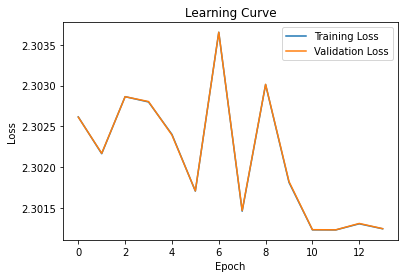

In [87]:
#Plot Learning Curves
import matplotlib.pyplot as plt
plt.plot(epoch_tr_losses, label = 'Training Loss')
plt.plot(epoch_val_losses, label = 'Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [88]:
evall(test_loader, model)

Accuracy: 11.35 %


11.35

In [89]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def cal_confusion_matrix(dl, model):
    preds = torch.empty((0))
    labels = torch.empty((0))
    for batch in dl:
        ip, op = batch
        pred = model(ip)
        #Get The Class With The Maximum Output Value
        v, pred = torch.max(pred.data, 1)
        #Increment The Number Of Samples Tested Against
        #Increment The Number Of Correctly Classified Samples
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, op))
    
    ConfusionMatrixDisplay.from_predictions(labels, preds)
    plt.show()

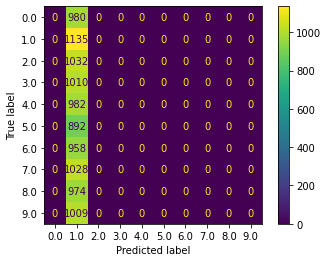

In [90]:
cal_confusion_matrix(test_loader, model)


## Results Dicussion

We can see that adding dropout has increased the time required by the model to reach a similar accuracy as before but it can be observed in the learning curves that the gap between the trainnig and validation loss has also decreased showing that dropout has a regularization effect. For a dropout of 0.25 the model converges after 12 epochs and reaches a final testing accuracy of 97%. Increasing the dropout, we notice  that the model now reaches a lower test accuracy of 91% after about 12 epochs but the gap between the training and validation loss has decreased even more. Finally, a dropout of 0.75 as expected makes it even more difficult to converge, with the model learning very slowly initially and reaching a test accuracy of just 11.35% after around 12 epochs. We stop the training after this point due to computational constraints. Therefore, we can observe that dropout aids in regularization but increases the time required by the model to converge and also, a higher dropout can make it very difficult for the model to learn anything.

# References

Therefore the following sources were referred to for this assignment (Mentioning all the sources at one place again):

- https://pytorch.org/docs/stable/index.html

- https://scikit-learn.org/0.21/documentation.html

- https://discuss.pytorch.org/t/how-to-do-a-stratified-split/62290

- https://github.com/satyajitghana/PadhAI-Course/blob/master/colab-notebooks/16_PyTorchCNN.ipynb

- https://androidkt.com/initialize-weight-bias-pytorch/

- https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE

- https://discuss.pytorch.org/t/performing-mini-batch-gradient-descent-or-stochastic-gradient-descent-on-a-mini-batch/21235/5

- https://stackoverflow.com/questions/60050586/pytorch-change-the-learning-rate-based-on-number-of-epochs



